## Load Libraries

In [ ]:
# IMPORTANT: role back pandas version to work with statsmodels library
pip install pandas==1.1.5

In [1]:
# Library imports for modeling
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import csv
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## ETL

In [2]:
df = pd.read_csv('nuveen_data.csv')
df.head()

,CONTACT_ID,sales_12M,redemption_12M,refresh_date
0,85102111664960504040,12599925.10,-6557184.99,12/31/2017
1,4492101,0.00,0.00,12/31/2017
2,85102140943881291064,0.00,-195.00,12/31/2017
3,85202121774856516280,1164.76,0.00,12/31/2017
4,0360380,3278.15,0.00,12/31/2017


In [3]:
# create a list of all unique contact id
unique_id_list = df['CONTACT_ID'].unique().tolist()

## ARIMA Sales Projection Pipeline

In [4]:
# get only a single contacts data
def project_sales(df, unique_id_list, index):
        
    # collect data on a given contact 
    sample_contact = df[(df == unique_id_list[index]).any(axis=1)]
    
    # data values check
    sum_sales_12M = sample_contact['sales_12M'].sum()
    sum_redemptions_12M = sample_contact['redemption_12M'].sum()
    
    # check that contact data is not all zero
    if sum_sales_12M and sum_redemptions_12M != 0.0:

        refresh_date_list = sample_contact['refresh_date'].tolist()

        sample_contact_2dt = sample_contact
        sample_contact_2dt['refresh_date'] = pd.to_datetime(sample_contact_2dt['refresh_date'])

        min_date, max_date = sample_contact_2dt['refresh_date'].min(), sample_contact_2dt['refresh_date'].max()

        sales_df = sample_contact_2dt[['refresh_date', 'sales_12M']]
        sales_df = sales_df.set_index('refresh_date')

        sales_data = sales_df['sales_12M'].resample('MS').mean()

        # create ARIMA function parameters
        p = d = q = range(0, 2)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

        # use grid search for parameter optimization
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(sales_data,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results_sales = mod.fit()
                except:
                    continue

        # fit ARIMA model
        mod = sm.tsa.statespace.SARIMAX(sales_data,
                                        order=(1, 1, 1),
                                        seasonal_order=(1, 1, 0, 12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results_sales = mod.fit()

        # project sales 12 months past the end of the data
        pred_uc = results_sales.get_forecast(steps=12)
        pred_ci = pred_uc.conf_int()

        pred_ci_mean = pred_ci
        pred_ci_mean['mean sales_12M'] = pred_ci_mean.mean(axis=1)

        mean_sales_list = pred_ci['mean sales_12M'].tolist()

        end_sales_data = sales_data[-1]
        start_sales_proj = mean_sales_list[0]

        proj_diff = end_sales_data - start_sales_proj

        adjusted_pred_ci = pred_ci_mean
        adjusted_pred_ci['adjusted_mean'] = adjusted_pred_ci['mean sales_12M'] + proj_diff

        adjusted_pred_cu_r = adjusted_pred_ci[['adjusted_mean']]
        adjusted_pred_cu_r.columns = ['projection']

        return sales_data, adjusted_pred_cu_r

C:\Users\student\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


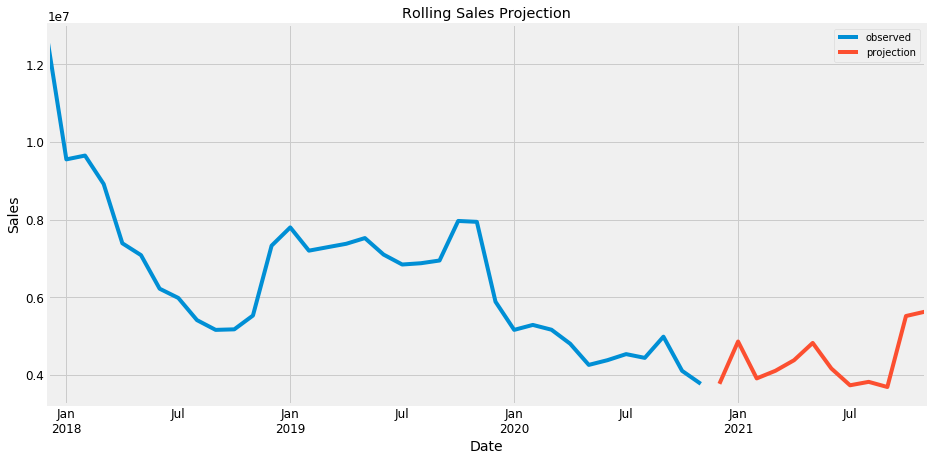

In [5]:
# project sales past the end of the data set 12 months into future with adjusted forecast
sales_data, adjusted_pred_cu_r = project_sales(df, unique_id_list, 0)

ax = sales_data.plot(label='observed', figsize=(14, 7))

adjusted_pred_cu_r.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Rolling Sales Projection')
plt.legend()
plt.show()

### ARIMA Redemptions Projection Pipeline

In [6]:
# get only a single contacts data
def project_redemptions(df, unique_id_list, index):
    
    # collect data on a given contact
    sample_contact = df[(df == unique_id_list[index]).any(axis=1)]
    
    # data values check
    sum_sales_12M = sample_contact['sales_12M'].sum()
    sum_redemptions_12M = sample_contact['redemption_12M'].sum()
    
    # check that contact data is not all zero
    if sum_sales_12M and sum_redemptions_12M != 0.0:

        refresh_date_list = sample_contact['refresh_date'].tolist()

        sample_contact_2dt = sample_contact
        sample_contact_2dt['refresh_date'] = pd.to_datetime(sample_contact_2dt['refresh_date'])

        min_date, max_date = sample_contact_2dt['refresh_date'].min(), sample_contact_2dt['refresh_date'].max()

        redemptions_df = sample_contact_2dt[['refresh_date', 'redemption_12M']]
        redemptions_df = redemptions_df.set_index('refresh_date')

        redemptions_data = redemptions_df['redemption_12M'].resample('MS').mean()

        # create ARIMA function parameters
        p = d = q = range(0, 2)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

        # use grid search for parameter optimization
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(redemptions_data,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results_redemptions = mod.fit()
                except:
                    continue

        # fit ARIMA model
        mod = sm.tsa.statespace.SARIMAX(redemptions_data,
                                        order=(1, 1, 1),
                                        seasonal_order=(1, 1, 0, 12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results_redemptions = mod.fit()

        # project sales 12 months past the end of the data
        pred_uc = results_redemptions.get_forecast(steps=12)
        pred_ci = pred_uc.conf_int()

        pred_ci_mean = pred_ci
        pred_ci_mean['mean redemptions_12M'] = pred_ci_mean.mean(axis=1)

        mean_redemptions_list = pred_ci['mean redemptions_12M'].tolist()

        end_redemptions_data = redemptions_data[-1]
        start_redemptions_proj = mean_redemptions_list[0]

        proj_diff = end_redemptions_data - start_redemptions_proj

        adjusted_pred_ci = pred_ci_mean
        adjusted_pred_ci['adjusted_mean'] = adjusted_pred_ci['mean redemptions_12M'] + proj_diff

        adjusted_pred_cu_s = adjusted_pred_ci[['adjusted_mean']]
        adjusted_pred_cu_s.columns = ['projection']

        return redemptions_data, adjusted_pred_cu_s

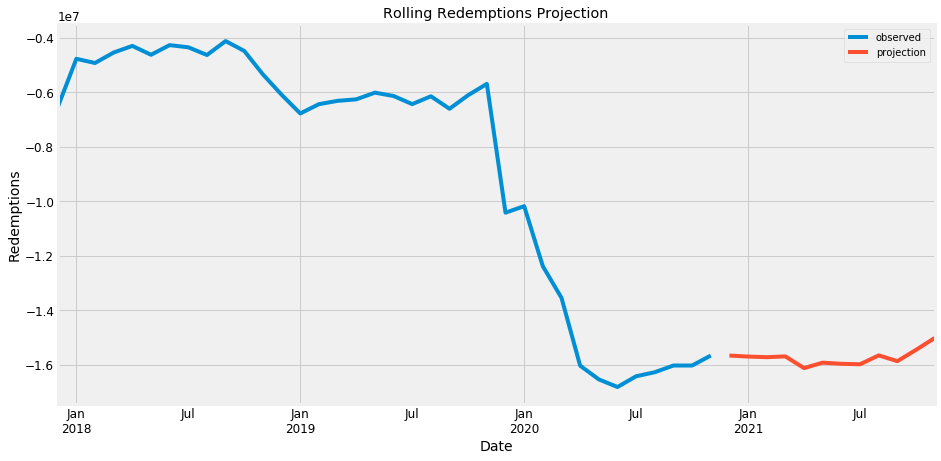

In [7]:
# project sales past the end of the data set 12 months into future with adjusted forecast
redemptions_data, adjusted_pred_cu_s = project_redemptions(df, unique_id_list, 0)

ax = redemptions_data.plot(label='observed', figsize=(14, 7))

adjusted_pred_cu_s.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Redemptions')
plt.title('Rolling Redemptions Projection')
plt.legend()
plt.show()

### Net Change of ARIMA Sales and Redemption Models

In [8]:
def project_net_sales(adjusted_pred_cu_s, adjusted_pred_cu_r, sales_data, redemptions_data):
    
    adj_pred_cu_merg = adjusted_pred_cu_s.merge(adjusted_pred_cu_r, left_index=True, right_index=True, how='inner')
    adj_pred_cu_merg.columns = ['sales_projection', 'redemptions_projection']
    
    adj_pred_cu_merg['net_projection'] = adj_pred_cu_merg['sales_projection'].sub(adj_pred_cu_merg['redemptions_projection'], axis=0)
    
    final_projection = adj_pred_cu_merg[['net_projection']]
    
    sales_data_df = sales_data.to_frame()
    redemptions_data_df = redemptions_data.to_frame()
    
    data_check = sales_data_df.merge(redemptions_data_df, left_index=True, right_index=True, how='inner')
    
    data_check['net_change'] = data_check['sales_12M'].sub(data_check['redemption_12M'], axis=0)
    
    actual_change = data_check[['net_change']]
    
    final_projection_list = final_projection['net_projection'].tolist()
    actual_change_list = actual_change['net_change'].tolist()

    end_actual_data = actual_change_list[-1]
    start_final_proj = final_projection_list[0]

    proj_diff = end_actual_data - start_final_proj
    
    adjusted_pred_ci = final_projection
    adjusted_pred_ci['adjusted_net'] = adjusted_pred_ci['net_projection'] + proj_diff
    
    adjusted_pred_cu_nc = adjusted_pred_ci[['adjusted_net']]
    adjusted_pred_cu_nc.columns = ['projection']
    
    return actual_change, adjusted_pred_cu_nc

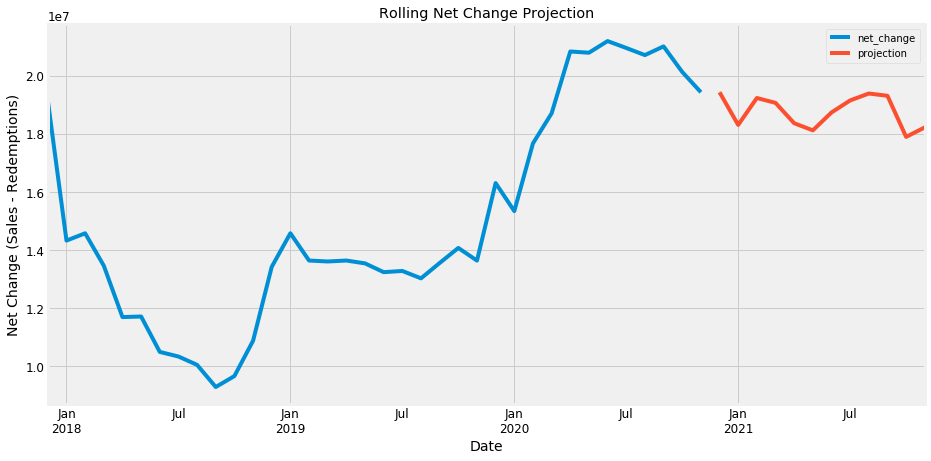

In [9]:
# project sales past the end of the data set 12 months into future with adjusted forecast
actual_change, adjusted_pred_cu_nc = project_net_sales(adjusted_pred_cu_s, adjusted_pred_cu_r, sales_data, redemptions_data)

ax = actual_change.plot(label='observed', figsize=(14, 7))

adjusted_pred_cu_nc.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Net Change (Sales - Redemptions)')
plt.title('Rolling Net Change Projection')
plt.legend()
plt.show()

### Calculate Projections for all Contacts

In [12]:
# calculates the 12 month projections for all clients
def get_all_projections(df, unique_id_list):
    
    contact_proj_dict = {}
    iterations = len(unique_id_list)
    
    for index in range(iterations):
        
        print('Calculating {} out of {} Projections'.format(index, iterations))
        
        try:
            sales_data, adjusted_pred_cu_r = project_sales(df, unique_id_list, index)

            redemptions_data, adjusted_pred_cu_s = project_redemptions(df, unique_id_list, index)
        except:
            print('SKIPPING: CONTACT_ID {} contains all zero data'.format(index))
            continue
            
        actual_change, adjusted_pred_cu_nc = project_net_sales(adjusted_pred_cu_s, adjusted_pred_cu_r, sales_data, redemptions_data)

        projection_list = adjusted_pred_cu_nc['projection'].tolist()
        last_projection = projection_list[-1]
        
        contact_proj_dict.update({unique_id_list[index]: last_projection})
    
    return contact_proj_dict

In [1]:
# create projections for all clients (took ~1 hour per 1,000 projections)
contact_proj_dict = get_all_projections(df, unique_id_list)

### Save Results

In [19]:
# save projections as csv
with open('nuveen_projections.csv', 'w') as f:
    for key in contact_proj_dict.keys():
        f.write("%s,%s\n"%(key,contact_proj_dict[key]))